1. 初始读取

In [1]:
%matplotlib qt
import mne
import matplotlib.pyplot as plt
import numpy as np

# 1. 设置文件路径  路径前加 r 可以避免转义字符报错
file_path = r'data/healthy_emotion/healthy/sub01_erp_raw.cnt'

# 2. 读取数据
print("正在读取数据...")
raw = mne.io.read_raw_cnt(file_path, preload=True)

# 3. 查看基础信息
print("\n--- 数据基础信息 ---")
print(f"受试者: sub01")
print(f"通道数 (n_channels): {len(raw.ch_names)}")
print(f"采样率 (sfreq): {raw.info['sfreq']} Hz")
print(f"时间长度: {raw.times[-1]} 秒")
print(f"通道名称: {raw.ch_names[:5]} ...") # 只打印前5个看看

# 让MNE知道 Trigger 不是脑电，后面的滤波、插值、重参考都会自动放过它
raw.set_channel_types({'Trigger': 'stim'})
# 4. 可视化波形 (看看数据长啥样) 会弹出一个交互式窗口，可以缩放查看波形
raw.plot(duration=5, n_channels=10, scalings='auto', title='EEG Data')

# 5. 提取事件 (Events/Triggers)
# 实验是有“视频”的，所以EEG里一定有标记说明视频什么时候开始
# 在.cnt文件中，events通常存储在 annotations 里
events, event_id = mne.events_from_annotations(raw)
print(f"\n共检测到 {len(events)} 个事件标记")
print(f"事件ID映射: {event_id}")

# 6. 获取数据矩阵 格式通常是: [通道数, 时间点数]
data_matrix = raw.get_data()
print(f"\n获得的矩阵形状: {data_matrix.shape}")

正在读取数据...
Reading 0 ... 4489099  =      0.000 ...  4489.099 secs...

--- 数据基础信息 ---
受试者: sub01
通道数 (n_channels): 65
采样率 (sfreq): 1000.0 Hz
时间长度: 4489.099 秒
通道名称: ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4'] ...
Using matplotlib as 2D backend.
Used Annotations descriptions: [np.str_('1'), np.str_('11'), np.str_('2'), np.str_('22'), np.str_('3'), np.str_('33'), np.str_('6'), np.str_('7'), np.str_('8')]

共检测到 54 个事件标记
事件ID映射: {np.str_('1'): 1, np.str_('11'): 2, np.str_('2'): 3, np.str_('22'): 4, np.str_('3'): 5, np.str_('33'): 6, np.str_('6'): 7, np.str_('7'): 8, np.str_('8'): 9}

获得的矩阵形状: (65, 4489100)


2. 验证标记与切分数据

In [ ]:
# 获取采样率
sfreq = raw.info['sfreq']

# 打印所有事件的发生时间点（采样点位置）
# events 数组的格式是：[采样点位置, 0, 事件ID]
print(f"采样率: {sfreq} Hz")

# 可视化事件分布图（一目了然看整个流程）
mne.viz.plot_events(events, sfreq=sfreq)

3. 滤波处理

In [ ]:
# l_freq=1.0 就是专门用来杀掉“基线漂移”；h_freq=75.0 用来杀掉高频噪音
print("正在进行滤波处理...")
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=75.0)

# 再次绘图对比
# 这一次应该能看到所有通道都乖乖地排成一列，围绕0轴震荡
raw_filtered.plot(duration=5, n_channels=10, scalings='auto', title='Filtered EEG Data')# picks='eeg' 确保只处理脑电通道


4. 陷波滤波，专门杀掉 50Hz

In [ ]:
# 中国和欧洲的数据通常是 50Hz，美国是 60Hz。如果50Hz没用，可以试试60Hz。
print("正在去除 50Hz 工频干扰...")
raw_filtered.notch_filter(freqs=50.0, picks='eeg')
raw_filtered.plot(duration=5, n_channels=20, scalings=dict(eeg=50e-6), title='Find Bad Channels')
# raw_filtered.plot(duration=5, n_channels=15, scalings='auto', title='Clean EEG (Notched)')

5. 插值修复 (Interpolation)

In [11]:
# 手动标记坏导，告诉 MNE 这3个通道是坏的，不要直接分析它们
raw_filtered.info['bads'] = ['FC3', 'FC1', 'P2']
# raw_filtered.info['bads'] = ['FC3', 'FC1', 'P2', 'FP1', 'FP2', 'FPZ', 'AF3', 'AF4']
# 检查一下是否标记成功
print(f"当前标记的坏导: {raw_filtered.info['bads']}")
# 进行插值修复 (Interpolate)，MNE 会自动根据头皮拓扑结构，利用周围好的电极计算出这两个点的信号
# reset_bads=False 表示修复后依然保留坏导标记（方便知道哪些修过），通常设为True也可以
raw_interpolated = raw_filtered.copy().interpolate_bads(reset_bads=True)

当前标记的坏导: ['FC3', 'FC1', 'P2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 1005.1 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors


C:\Users\goo\AppData\Local\Temp\ipykernel_3720\3953102089.py:8: RuntimeWarning: Estimated head radius (100.5 cm) is above the 99th percentile for adult head size.
  raw_interpolated = raw_filtered.copy().interpolate_bads(reset_bads=True)


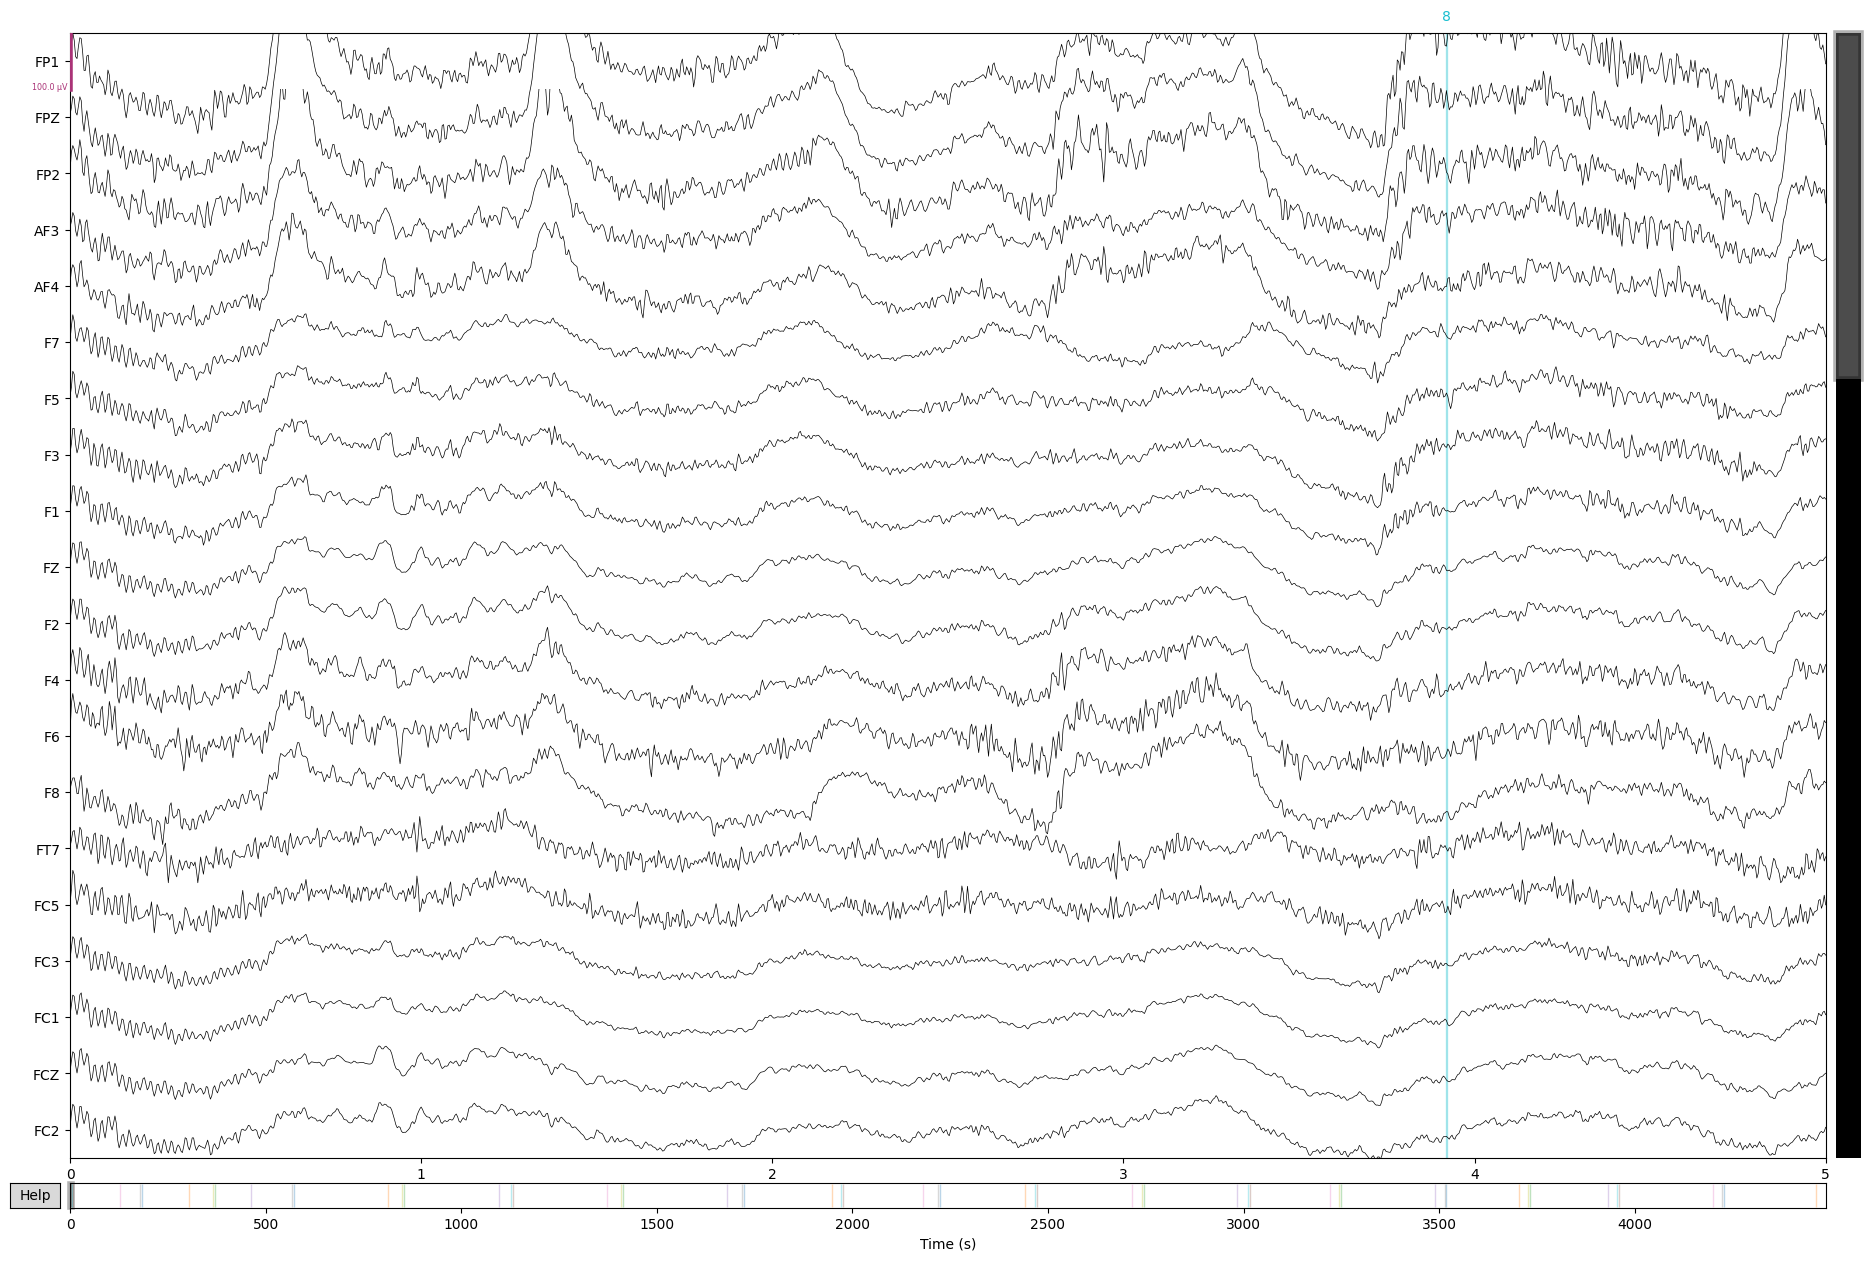

In [13]:
raw_interpolated.plot(duration=5, n_channels=20, scalings=dict(eeg=50e-6), title='Interpolated EEG')

6. 平均重参考 (Common Average Reference, CAR)

In [ ]:
# projection=False 表示直接应用计算，立即改变数据
raw_reref = raw_interpolated.copy().set_eeg_reference(ref_channels='average', projection=True)

# 再次画图会发现波形变得更"平整"
raw_reref.plot(duration=5, n_channels=20, scalings=dict(eeg=50e-6), title='Average Referenced EEG')

**第一战区：眼部与前额 (最容易脏)**

* **通道：** `FP1`, `FPZ`, `FP2`, `AF3`, `AF4`
* **位置：** 眉毛上方，发际线边缘。
* **特点：** **极易受眨眼干扰！** 这是为什么刚才重参考时，这几个通道把整个数据搞乱了。它们离眼球太近了。

**第二战区：核心思考区 (额叶)**

* **通道：** `F7`, `F5`, `F3`, `F1`, `FZ`, `F2`, `F4`, `F6`, `F8`
* **位置：** 前额头皮。
* **特点：** 负责情绪调控和认知。做情绪分类时，这里很重要。

**第三战区：运动与感觉区 (中央)**

* **通道：** `FC`系列 (`FC5`...`FC6`), `C`系列 (`C5`...`C6`), `CP`系列 (`CP5`...`CP6`)
* **位置：** 头顶。
* **特点：** `C3`, `C4` 也就是负责手部运动的地方（运动想象任务的核心区）。

*第四战区：视觉区 (后脑勺 - 你的重点)**

* **通道：** `P`系列 (`P7`...`P8`), `PO`系列, `O`系列 (`O1`, `OZ`, `O2`), `CB`系列 (`CB1`, `CB2`)
* **位置：** 后脑勺和脖子上方。
* **特点：** **因为你给受试者看了视频，O 区（枕叶）的信号会非常活跃。**
* *注：`CB` 指 Cerebellum (小脑)，位置很靠下，容易受到脖子肌肉紧张（低头）的干扰。*

**第五战区：听觉与语言 (两侧)**

* **通道：** `T7`, `T8`, `TP7`, `TP8`, `FT7`, `FT8`
* **位置：** 耳朵上方。
* **特点：** 容易受到**咬牙**（咬肌运动）的干扰。

**特殊通道**

* **M1, M2:** 耳后乳突。通常用来做参考。
* **Trigger:** 这不是电极，是同步信号线。
总结与建议
1. **FP1/FP2/FPZ** 是前额，离眼睛最近。
2. 受试者可能在实验中频繁眨眼或眼球转动。
3. 这些大幅度的**眼电伪迹 (EOG Artifacts)** 混入了 FP 通道。
4. 在做“平均重参考”时，这些巨大的眼电噪音被平均到了所有通道里。

7. ICA

正在拟合 ICA，请稍候...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 164.6s.
ICA 计算完成！
Creating RawArray with float64 data, n_channels=20, n_times=4489100
    Range : 0 ... 4489099 =      0.000 ...  4489.099 secs
Ready.


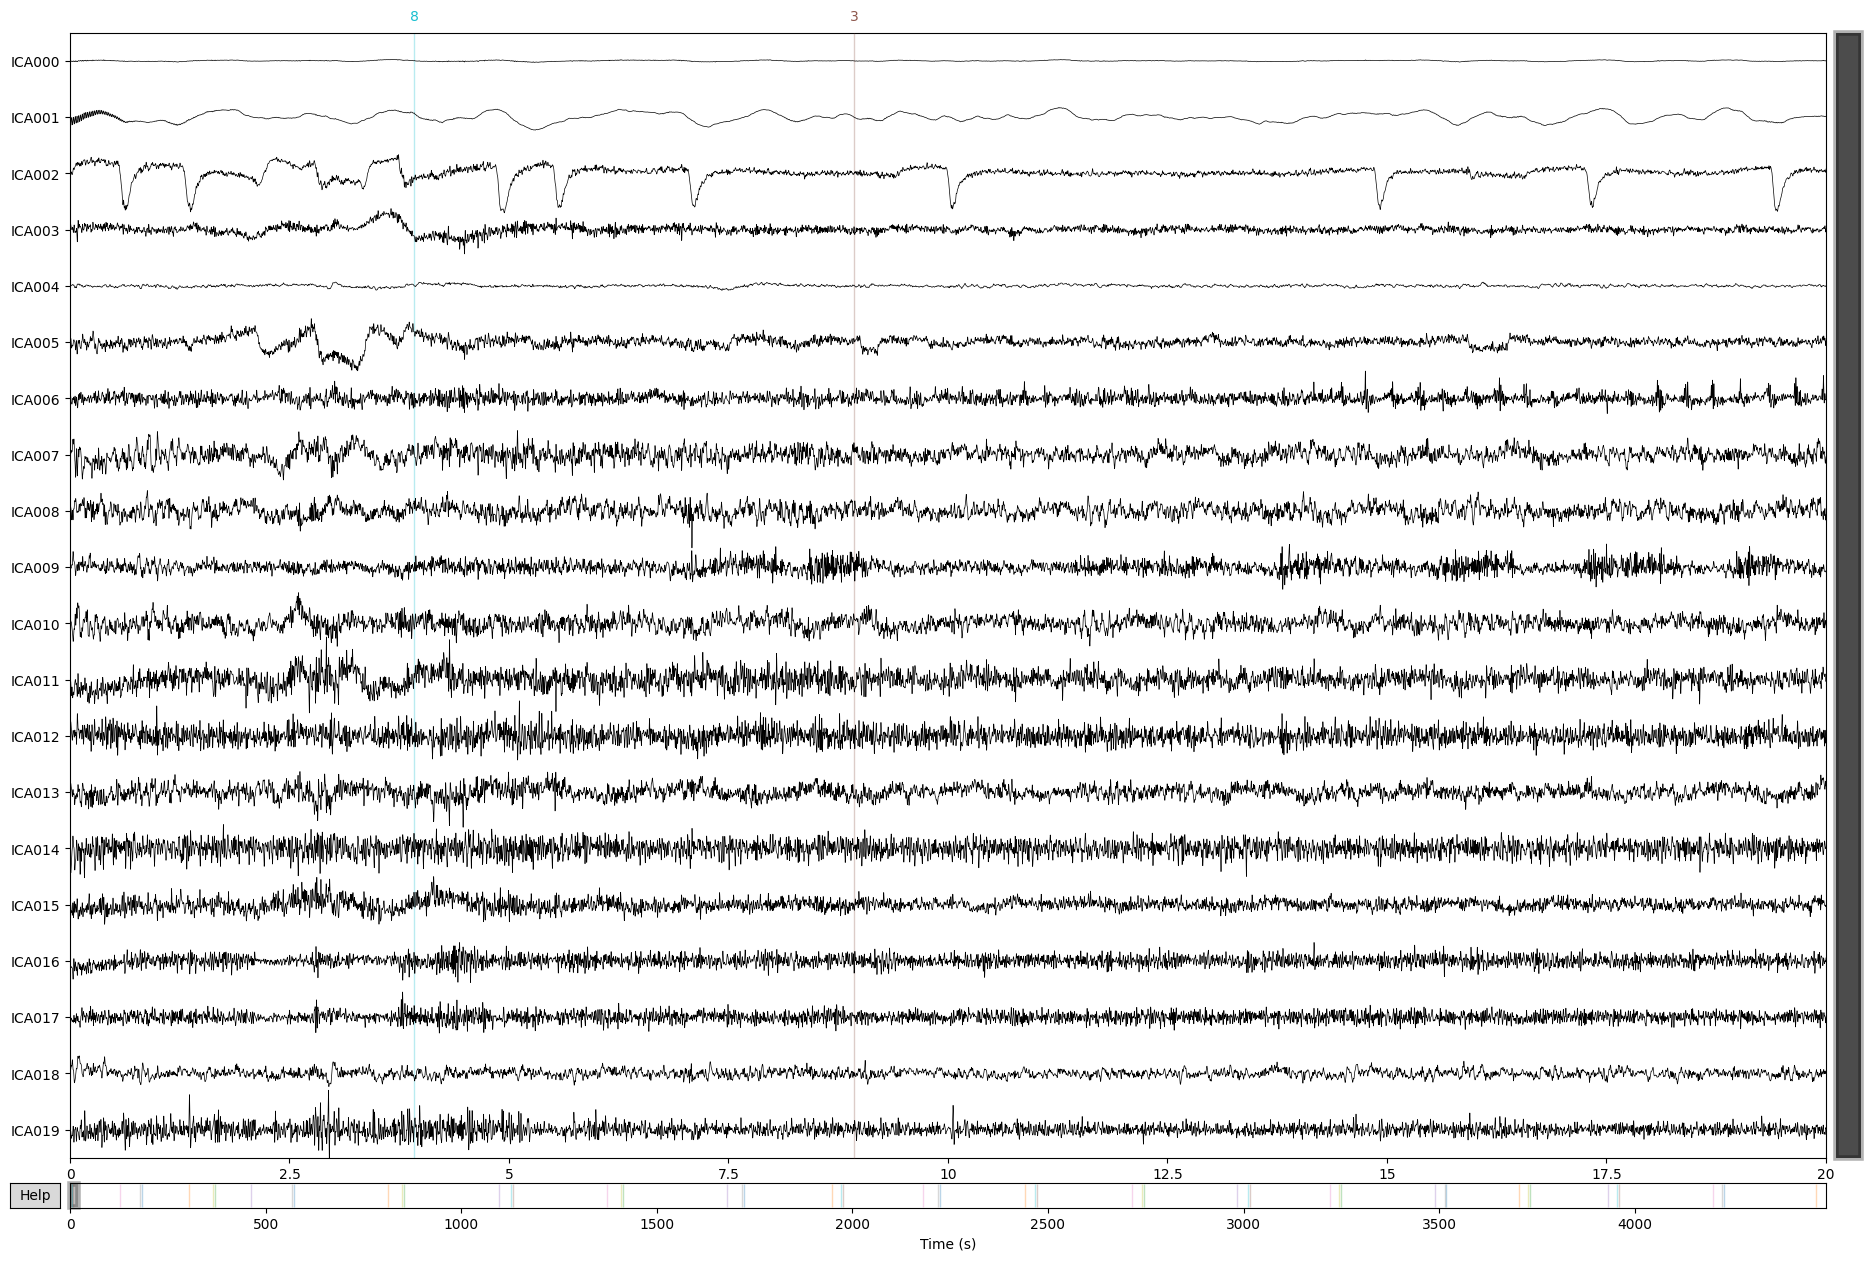

In [15]:
from mne.preprocessing import ICA

# 1. 配置 ICA，我们只提取前 20 个主要成分 (通常眼电都在前几个成分里，不用算满 64 个，那样太慢且没必要)
ica = ICA(n_components=20, random_state=97, max_iter=800)

# 2. 拟合 ICA (Fit) 这一步是让算法去学习哪些是独立的成分
print("正在拟合 ICA，请稍候...")
# picks='eeg' 确保只分析脑电，再次避开 Trigger
ica.fit(raw_reref, picks='eeg')

print("ICA 计算完成！")

# 3. 可视化成分地形图 需要在这张图里找出长得像"眼睛"的成分
ica.plot_components()

# 4. 可视化成分波形辅助判断 会弹出类似脑电图的波形，用来确认那个成分是不是在有规律地跳动(眨眼)
ica.plot_sources(raw_reref, show_scrollbars=True)

眨眼 (Blink) ICA004 5

8. ICA 剔除眼动信号

最终执行剔除的成分 ID: [2, 3, 5]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


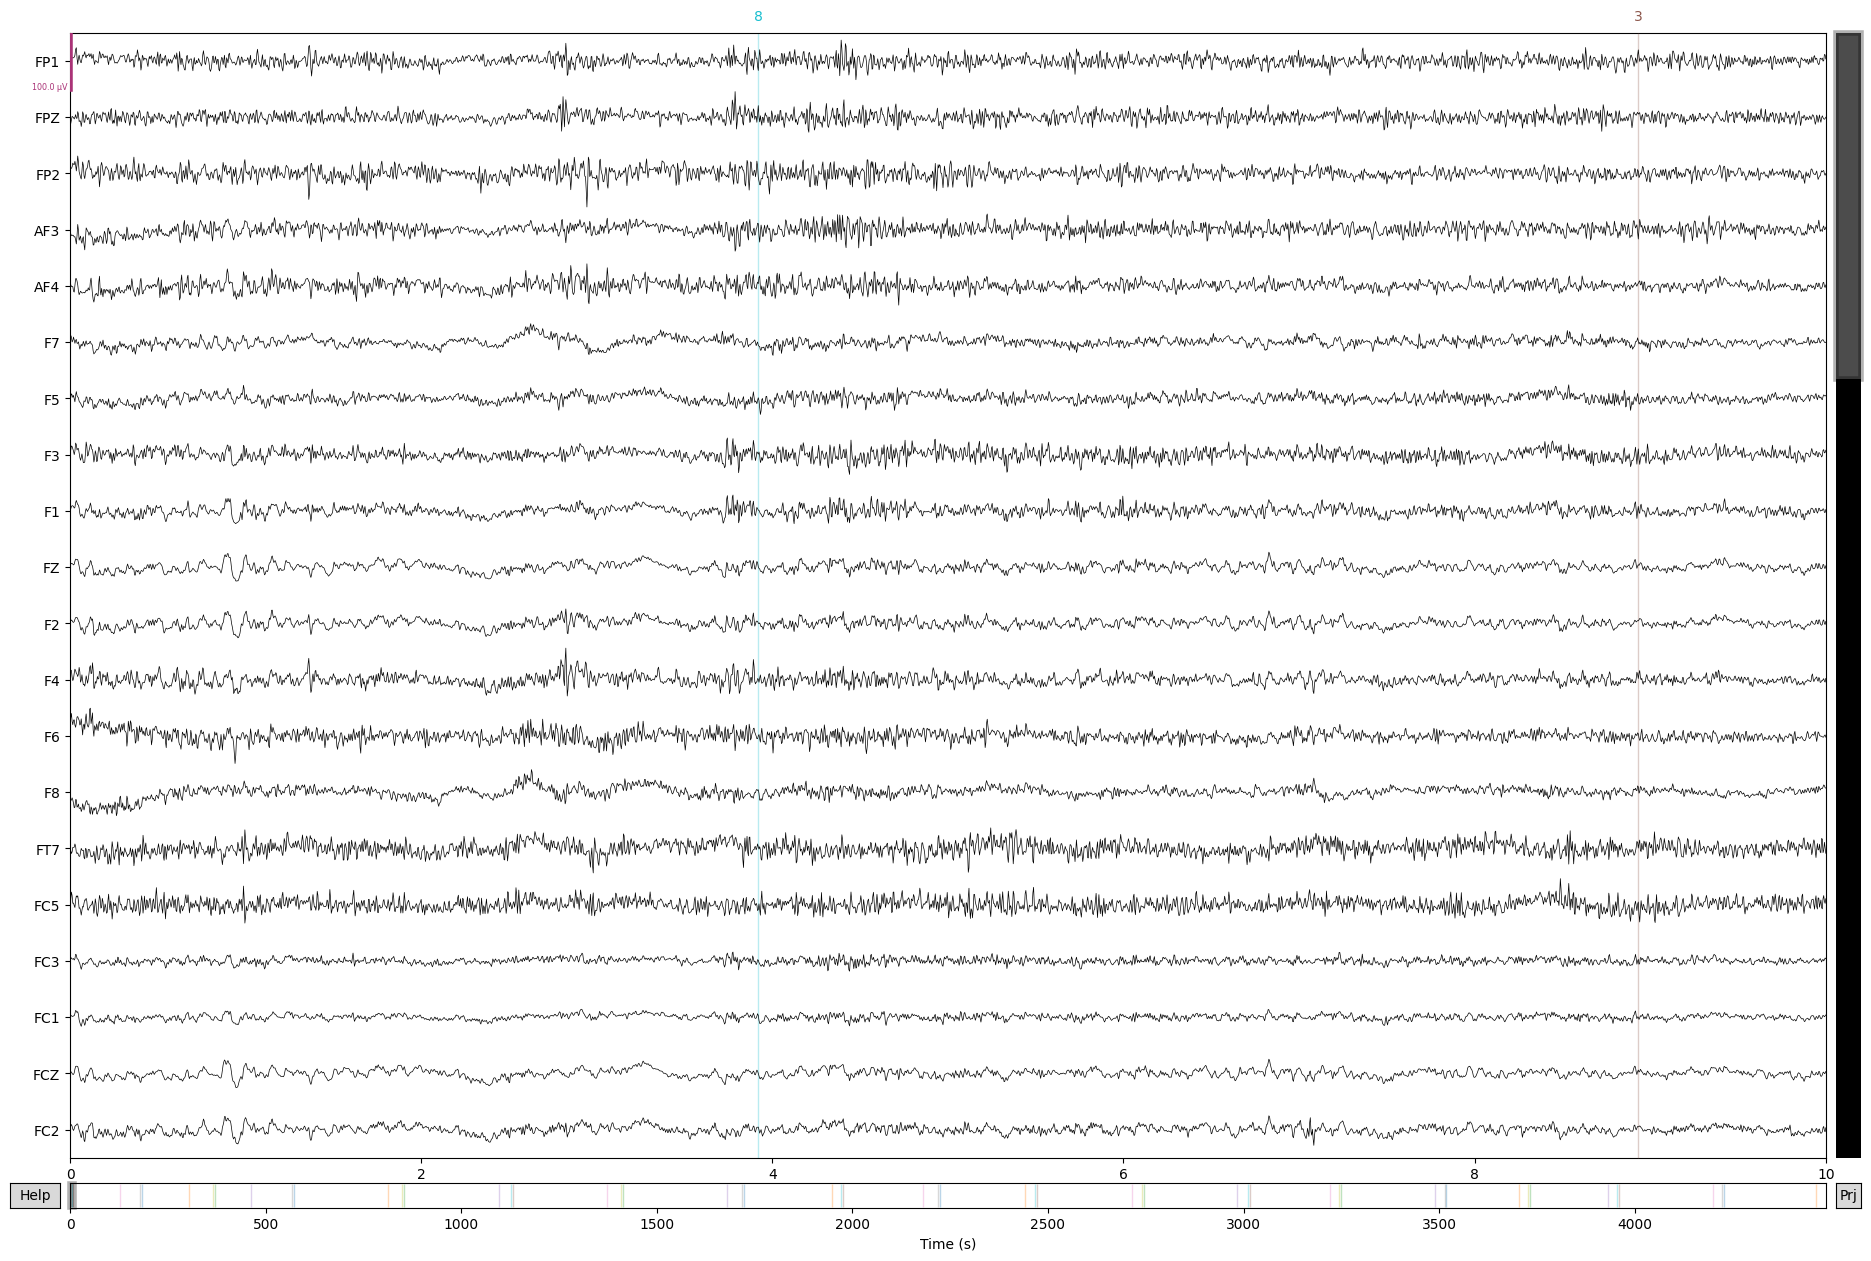

In [16]:
# 只剔除最确定的垂直眼动和眨眼
# ICA004: 眨眼 (Blink)
# ICA005: 伴随的垂直眼动 (Vertical EOG)
ica.exclude = [2, 3, 5]

print(f"最终执行剔除的成分 ID: {ica.exclude}")

# 应用剔除，生成最终的干净数据，这一步会把 [4, 5] 的影响从数据里减掉，保留其他成分
raw_clean = raw_reref.copy()
ica.apply(raw_clean)

# 最终检查会发现 FP1/FP2 变得干净了，但数据的整体结构没有被破坏
raw_clean.plot(duration=10, n_channels=20,
               scalings=dict(eeg=50e-6),
               title='Final Clean EEG (ICA Applied)')

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 1005.1 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


C:\Users\goo\AppData\Local\Temp\ipykernel_3720\1795601797.py:5: RuntimeWarning: Estimated head radius (100.5 cm) is above the 99th percentile for adult head size.
  raw_clean = raw_clean.copy().interpolate_bads(reset_bads=True, mode='accurate')


正在重新计算平均参考...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


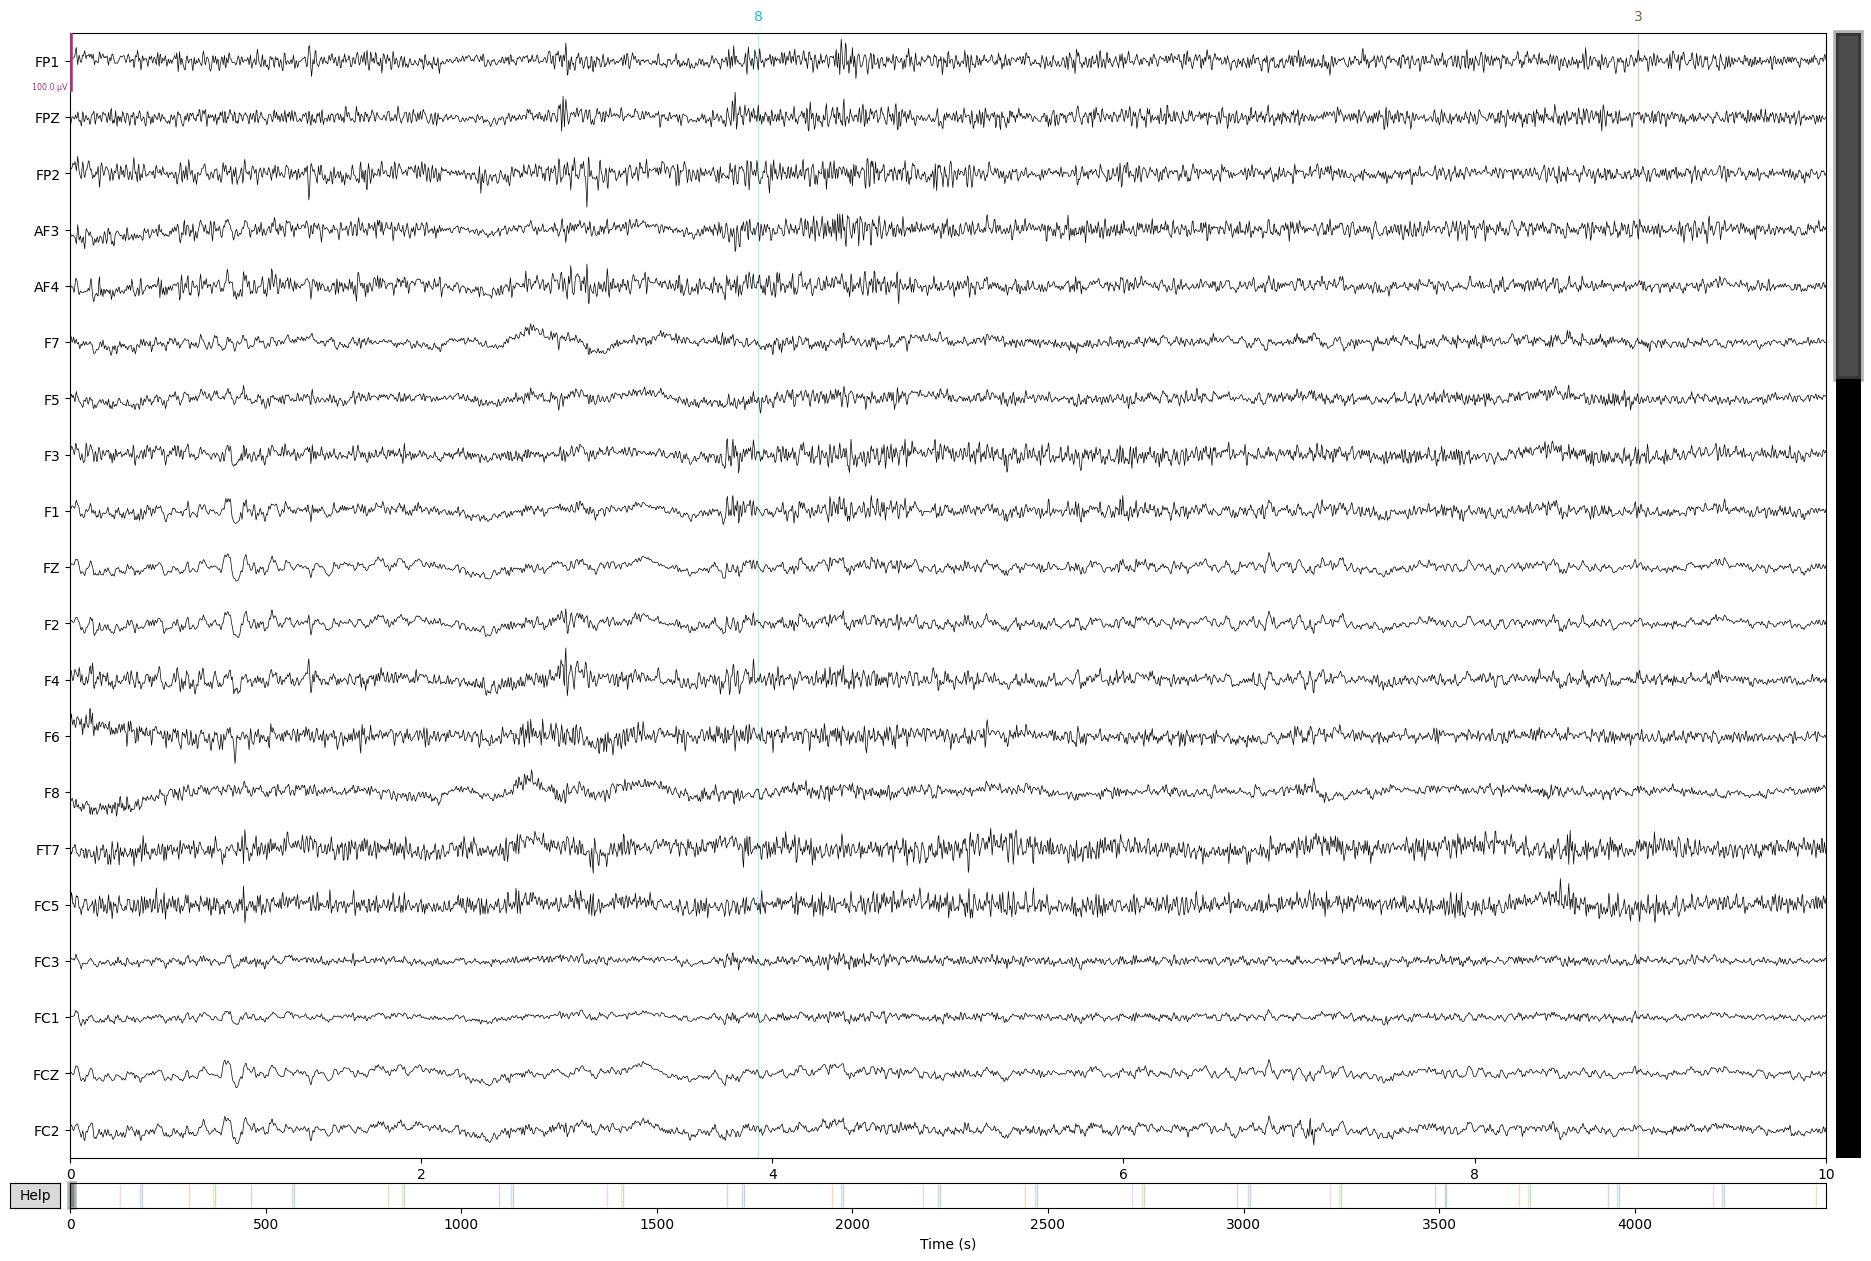

In [27]:
# 1. 标记坏导
raw_clean.info['bads'] = ['P7']

# 2. 插值修复 (用邻居修好它)
raw_clean = raw_clean.copy().interpolate_bads(reset_bads=True, mode='accurate')

# 3. 再画图看看，保证它变好了
raw_clean.plot(duration=10, n_channels=20, title='Fixed P7')

print("正在重新计算平均参考...")

# 1. 这一步会用现在“干净的 P7”和大家一起，重新计算一个准确的平均值
# 2. 然后把这个新平均值减掉，其他通道瞬间就会变平稳！
raw_clean.set_eeg_reference(ref_channels='average', projection=False)

# 3. 再次检查
raw_clean.plot(duration=10, n_channels=20,
               scalings=dict(eeg=50e-6),
               title='Fixed P7 + Re-referenced')

9. 数据切分

In [ ]:
# 查看Trigger
events, event_id = mne.events_from_annotations(raw_clean)

# 打印出所有的 Trigger 种类
print("------------------------------------------------")
print(f"检测到的所有 Trigger ID: {event_id}")
print("------------------------------------------------")

# 3. 事件长什么样，格式: [时间点, 0, Trigger编号]
print(events)
print(len(events))

import matplotlib.pyplot as plt

# 画出事件发生的时间点
fig = mne.viz.plot_events(events, sfreq=raw_clean.info['sfreq'], first_samp=raw_clean.first_samp)

Trigger '1' (ID 1): Neutral (中性)

Trigger '2' (ID 3): Happy (开心)

Trigger '3' (ID 5): Sad (悲伤)

Used Annotations descriptions: [np.str_('1'), np.str_('11'), np.str_('2'), np.str_('22'), np.str_('3'), np.str_('33'), np.str_('6'), np.str_('7'), np.str_('8')]
总共检测到 18 个视频，剔除 3 个练习后，剩余 15 个正式视频。
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 450 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['M1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['M1', 'CP3']
    Rejecting  epoch based on EEG : ['FPZ', 'M1']
    Rejecting  epoch based on EEG : ['CP3']

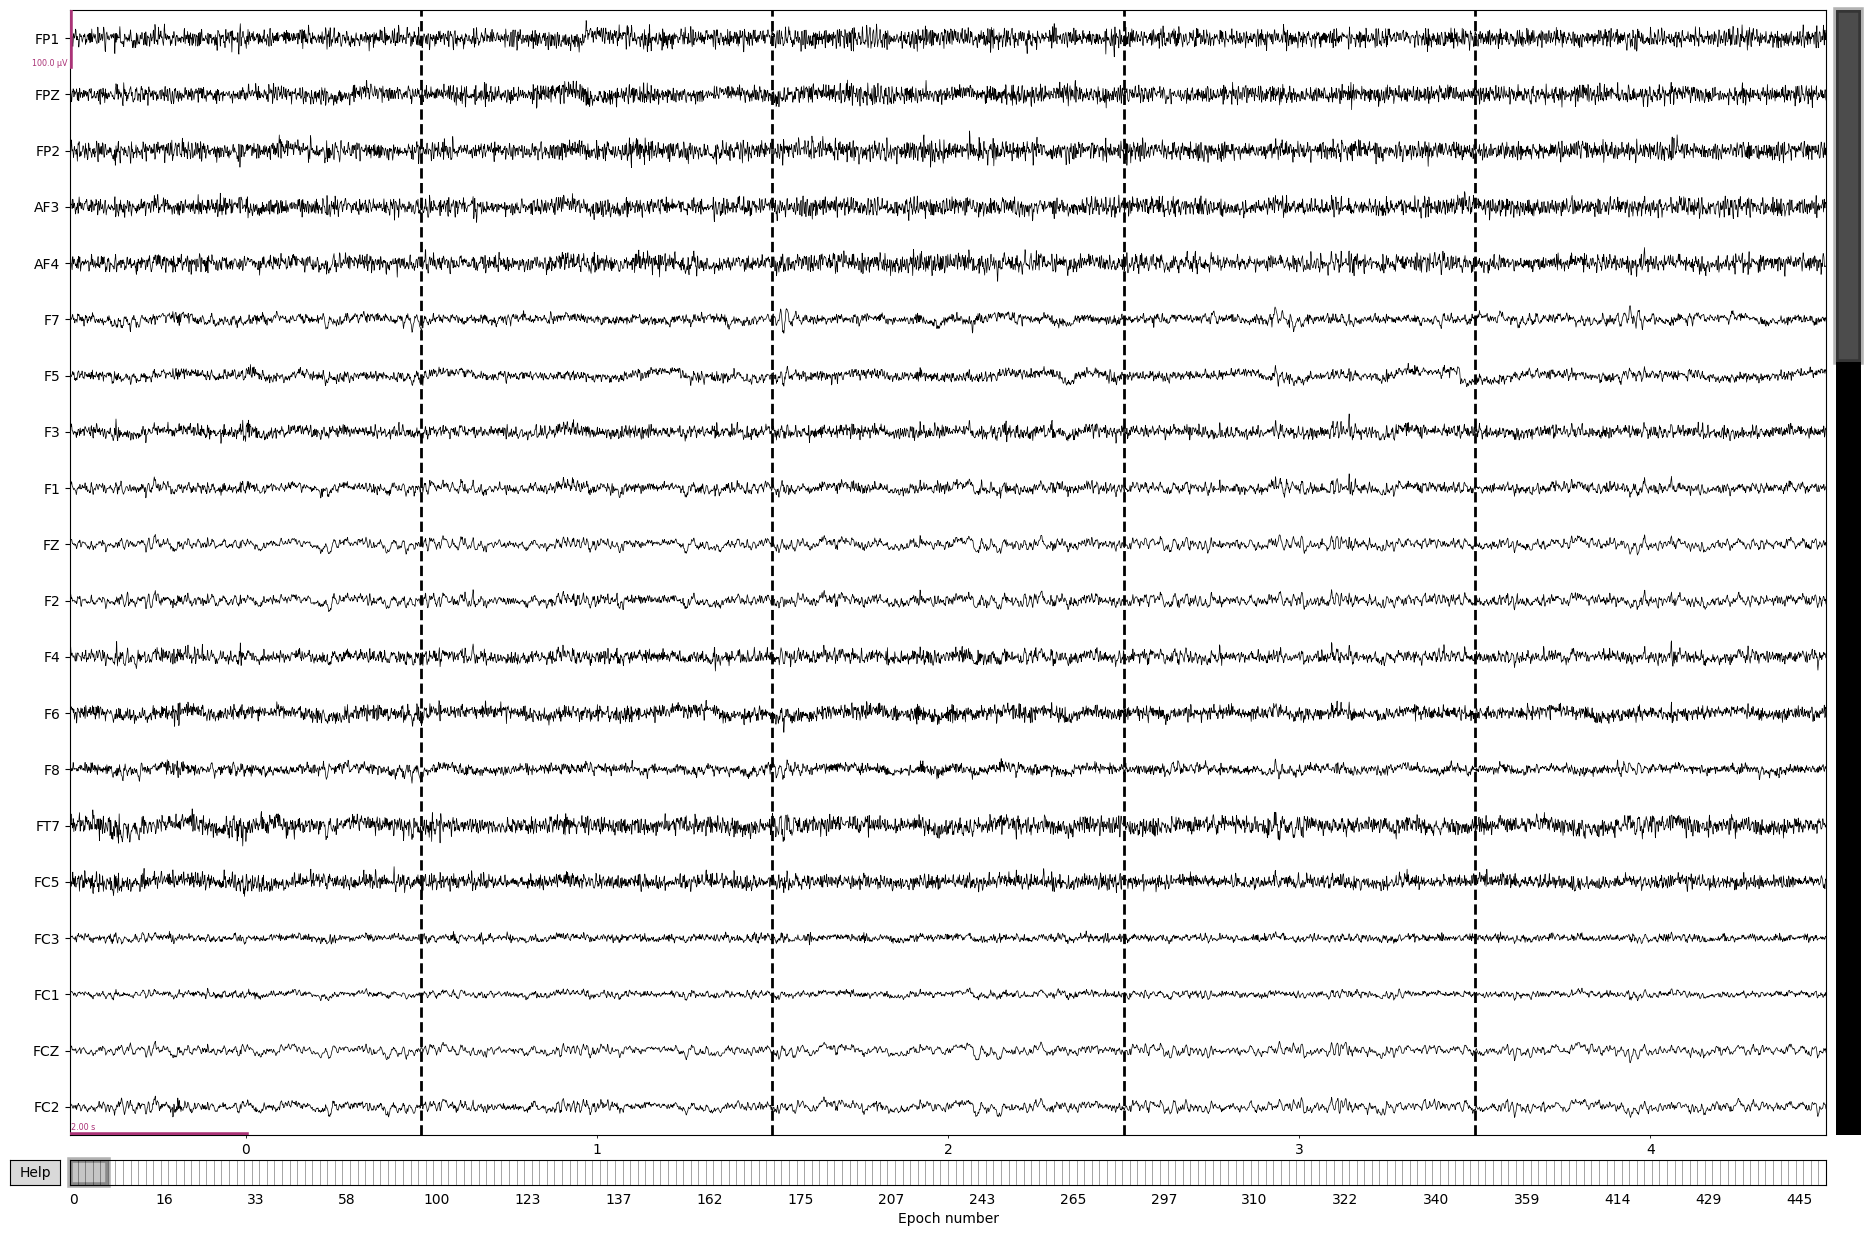

In [29]:
import numpy as np
import mne

# ==========================================
# 1. 定义正确的映射字典 (基于时长匹配推导)
# ==========================================
event_id_map = {
    'Neutral': 1,  # MNE ID 1 (原始 Trigger '1')
    'Happy': 3,    # MNE ID 3 (原始 Trigger '2')
    'Sad': 5       # MNE ID 5 (原始 Trigger '3')
}

# ==========================================
# 2. 预处理 Events：剔除练习阶段
# ==========================================
# 你的数据里有 18 对开始/结束标记。
# 我们需要找到所有"视频开始"的事件 (ID 为 1, 3, 5 的)
# 然后扔掉前 3 个，只保留后 15 个。

# 提取所有事件
all_events, _ = mne.events_from_annotations(raw_clean)

# 筛选出只是"开始"的事件 (ID 在 1,3,5 中)
start_events = all_events[np.isin(all_events[:, 2], [1, 3, 5])]

# 【关键步骤】剔除前 3 个练习 trial
real_trials = start_events[3:]
print(f"总共检测到 {len(start_events)} 个视频，剔除 3 个练习后，剩余 {len(real_trials)} 个正式视频。")

# ==========================================
# 3. 滑动窗口切分 (Sliding Window Epoching)
# ==========================================
# 为了增加样本量，我们把每个长视频切成多个 4秒 的小片段
t_window = 4.0  # 每个片段 4秒
n_crops = 30    # 每个视频切 30 刀 (共取 120秒 数据，避开视频头尾的不稳定)

new_events = []

for trial in real_trials:
    onset = trial[0]
    code = trial[2]

    # 从视频开始后 5秒 开始切 (避开开头受试者适应期)
    start_time = onset + int(5.0 * raw_clean.info['sfreq'])

    for i in range(n_crops):
        # 计算每个 4秒 片段的采样点位置
        curr_sample = start_time + int(i * t_window * raw_clean.info['sfreq'])
        new_events.append([curr_sample, 0, code])

new_events = np.array(new_events)

# ==========================================
# 4. 生成 Epochs
# ==========================================
epochs = mne.Epochs(raw_clean,
                    new_events,
                    event_id=event_id_map,
                    tmin=0,
                    tmax=4.0,       # 4秒长度
                    baseline=None,  # 情绪分类通常直接用 raw 数据，不做额外基线
                    preload=True,
                    reject=dict(eeg=100e-6)) # 再次清洗坏段

print(f"最终切分出 {len(epochs)} 个样本！")
epochs.plot(n_epochs=5, scalings=dict(eeg=50e-6), title='Final Epoched Data')

In [ ]:
import matplotlib.pyplot as plt

# 1. 单独提取 P7 的数据
# pick_channels 把它拎出来
p7_epoch = mne.Epochs(raw_clean, new_events, event_id=event_id_map,
                      tmin=0, tmax=4.0, baseline=(0, 4), reject=None,
                      picks=['P7'], preload=True)

data_p7 = p7_epoch.get_data() # 形状: (n_epochs, 1, n_times)

# 2. 打印它的真实数值
print("========== P7 通道身体检查 ==========")
print(f"P7 最大值: {data_p7.max() * 1e6 :.2f} µV")
print(f"P7 最小值: {data_p7.min() * 1e6 :.2f} µV")
print(f"P7 平均值: {data_p7.mean() * 1e6 :.2f} µV")

# 3. 看看前 5 个片段长什么样 (不准 MNE 自动美颜)
# 我们用 Matplotlib 直接画原始数据，不让 MNE 做缩放
plt.figure(figsize=(10, 4))
plt.plot(data_p7[0, 0, :] * 1e6, label='Epoch 1') # 画第1个片段
plt.plot(data_p7[1, 0, :] * 1e6, label='Epoch 2') # 画第2个片段
plt.plot(data_p7[2, 0, :] * 1e6, label='Epoch 3') # 画第3个片段
plt.axhline(200, color='r', linestyle='--', label='Threshold +200') # 画出警戒线
plt.axhline(-200, color='r', linestyle='--', label='Threshold -200')
plt.title("Trace of P7 (Raw Data)")
plt.ylabel("Microvolts (µV)")
plt.legend()
plt.show()

In [31]:
import numpy as np
from collections import Counter

# 这里的 epochs 必须是你刚刚切分出 232 个样本的那个变量
print(f"总共切分尝试: 450 个")
print(f"最终保留: {len(epochs)} 个")
print(f"丢弃数量: {450 - len(epochs)} 个")

# 分析 drop_log (MNE 会记录每一个被丢弃样本的原因)
# drop_log 是一个列表，如果某样本没被丢，它是空的；如果被丢了，里面会有通道名
bad_channels_count = []

for log in epochs.drop_log:
    if len(log) > 0:
        # log 里的 'USER' 表示手动丢弃，我们要找的是通道名（如 'T7', 'Fp1'）
        # 过滤掉非通道名的标记
        ch_names = [ch for ch in log if ch not in ['IGNORED', 'USER']]
        bad_channels_count.extend(ch_names)

# 打印排行榜
print("\n========== 谁导致了这 218 个样本被丢弃？ ==========")
if bad_channels_count:
    counts = Counter(bad_channels_count)
    # 打印前 5 名
    for ch, count in counts.most_common(5):
        print(f"通道 {ch}: 在 {count} 个样本中超标")
else:
    print("没有特定的通道超标？可能是其他原因。")

总共切分尝试: 450 个
最终保留: 232 个
丢弃数量: 218 个

========== 谁导致了这 218 个样本被丢弃？ ==========
通道 CP3: 在 148 个样本中超标
通道 T7: 在 83 个样本中超标
通道 TP7: 在 51 个样本中超标
通道 M1: 在 43 个样本中超标
通道 C3: 在 32 个样本中超标


In [32]:
# ==========================================
# 插值 CP3 + 放宽阈值
# ==========================================

print("1. 处理左侧坏导区域...")
# CP3 是这次的罪魁祸首，必须修好它
# 如果你觉得 T7 (83次) 也很碍事，可以把 T7 也加进去: ['CP3', 'T7']
raw_clean.info['bads'] = ['CP3']
print(f"已标记坏导: {raw_clean.info['bads']}")

# 2. 插值修复
# 用周围健康的右侧或中间电极，把 CP3 算回来
raw_final = raw_clean.copy().interpolate_bads(reset_bads=True, mode='accurate')

# 3. 重新计算平均参考 (清除坏导留下的污染)
# 这一步能让所有通道都变平稳
raw_final.set_eeg_reference(ref_channels='average', projection=False)

# ==========================================
# 4. 最终切分 (见证奇迹)
# ==========================================
# 策略：修好了 CP3，且把门槛从 200 提到 300
# 这样 T7, TP7 那些稍微吵一点的数据也能被保留下来
reject_criteria = dict(eeg=300e-6)

epochs_final = mne.Epochs(raw_final,
                          new_events,
                          event_id=event_id_map,
                          tmin=0,
                          tmax=4.0,
                          baseline=(0, 4),
                          preload=True,
                          reject=reject_criteria)

print(f"最终保留样本数: {len(epochs_final)} / 450")

# 5. 保存 (不论剩下多少，这已经是能榨出的极限了)
if len(epochs_final) > 300:
    save_path = 'data/data_cleaned/sub01_final_cleaned.fif'
    epochs_final.save(save_path, overwrite=True)
    print(f"\n恭喜！这就叫'保大又保小'！数据已保存至: {save_path}")
else:
    print("\n数量还是不多？那可能左边的 T7 也得插值修一下。")

1. 处理左侧坏导区域...
已标记坏导: ['CP3']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 1005.1 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


C:\Users\goo\AppData\Local\Temp\ipykernel_3720\1839429476.py:13: RuntimeWarning: Estimated head radius (100.5 cm) is above the 99th percentile for adult head size.
  raw_final = raw_clean.copy().interpolate_bads(reset_bads=True, mode='accurate')


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
450 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 450 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['M2']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['P1', 'POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['M1', 'POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
    Rejecting  epoch based on EEG : ['POZ']
13 bad epochs dropped
最终保留样本数: 437 / 450


C:\Users\goo\AppData\Local\Temp\ipykernel_3720\1839429476.py:40: RuntimeWarning: This filename (sub01_final_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_final.save(save_path, overwrite=True)



恭喜！这就叫'保大又保小'！数据已保存至: sub01_final_cleaned.fif


In [33]:
# ==========================================
# 严谨性检查：你的数据真的只有噪声吗？
# ==========================================

# 1. 画出所有样本的平均功率谱 (PSD)
# 这一步能看到不同频率的能量分布
# fmax=60 只需要看 60Hz 以下的，因为这是脑电的主要频段
epochs_final.plot_psd(fmin=1, fmax=60, average=True, spatial_colors=True)

print("请观察生成的 PSD 图：")
print("1. 是否有明显的 Alpha 波峰？ (通常在 8-12 Hz 有个凸起)")
print("2. 是否遵循 1/f 分布？ (曲线整体应该是从左上往右下衰减的)")

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
请观察生成的 PSD 图：
1. 是否有明显的 Alpha 波峰？ (通常在 8-12 Hz 有个凸起)
2. 是否遵循 1/f 分布？ (曲线整体应该是从左上往右下衰减的)
